In [ ]:
# ==============================================================================
# ML-CUP25 - KNN Regression Model
# ------------------------------------------------------------------------------
# Author: Gabriele Righi
# Date: 2025
# Description:
#   This script trains a K-Nearest Neighbors (KNN) regressor to solve the
#   ML-CUP25 multi-target regression problem.
#
#   Workflow:
#   1. Data Loading & Cleaning
#   2. Data Splitting (80% Development / 20% Blind Test)
#   3. Model Selection via Grid Search (5-Fold Cross-Validation)
#   4. Evaluation on Blind Test Set (MSE, R2, and MEE)
#   5. Visual Diagnostics (Actual vs. Predicted Plots)
# ==============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_squared_error, r2_score

In [7]:
# ==============================================================================
# 1. DATA LOADING & PREPARATION
# ==============================================================================

# Load dataset (handling comment lines starting with '#')
filename = 'ML-CUP25-TR.csv'
column_names = None # No header in the file

try:
    df = pd.read_csv(filename, comment='#', header=None)
    print(f"Dataset loaded successfully. Shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: File '{filename}' not found. Please upload the dataset.")
    exit()

# Separate Features (X) and Targets (y)
# Column 0: ID (discarded)
# Columns 1 to 12: Input Features
# Columns 13 to 16: Targets (Last 4 columns)
X = df.iloc[:, 1:-4].values
y = df.iloc[:, -4:].values

print(f"Input Features (X): {X.shape}")
print(f"Targets (y): {y.shape}")

# Split Data: 80% Development (Train+Val) / 20% Test (Blind)
# random_state=42 ensures reproducibility
X_dev, X_test, y_dev, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

print(f"Development Set: {X_dev.shape[0]} samples")
print(f"Test Set: {X_test.shape[0]} samples")



Dataset loaded successfully. Shape: (500, 17)
Input Features (X): (500, 12)
Targets (y): (500, 4)
Development Set: 400 samples
Test Set: 100 samples


In [8]:
# ==============================================================================
# 2. MODEL DEFINITION & GRID SEARCH
# ==============================================================================

# Define Custom Scorer: Mean Euclidean Error (MEE)
# The competition metric is MEE. GridSearchCV maximizes score,
# so we return the negative MEE.
def mee_score_func(y_true, y_pred):
    # Euclidean distance for each sample
    dist = np.sqrt(np.sum(np.power(y_true - y_pred, 2), axis=1))
    return np.mean(dist)

# 'greater_is_better=False' tells sklearn that lower MEE is better
mee_scorer = make_scorer(mee_score_func, greater_is_better=False)

# Build Pipeline:
# 1. MinMaxScaler: Scales features to [0, 1]. found to differnetiate better
#    than StandardScaler for this specific dataset.
# 2. KNeighborsRegressor: The regression model.
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('knn', KNeighborsRegressor())
])

# Define Hyperparameter Grid for Search
# We search for the best K, weight function, and distance metric.
param_grid = {
    'knn__n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10], # Range of neighbors
    'knn__weights': ['uniform', 'distance'],       # Weighting strategy
    'knn__metric': ['euclidean', 'manhattan']      # Distance metric
}

print("\n--- Starting Grid Search (5-Fold Cross-Validation) ---")
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring=mee_scorer,
    n_jobs=-1, # Use all available CPU cores
    verbose=1
)

# Fit on Development Set
grid_search.fit(X_dev, y_dev)


--- Starting Grid Search (5-Fold Cross-Validation) ---
Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('knn', KNeighborsRegressor())]),
             n_jobs=-1,
             param_grid={'knn__metric': ['euclidean', 'manhattan'],
                         'knn__n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10],
                         'knn__weights': ['uniform', 'distance']},
             scoring=make_scorer(mee_score_func, greater_is_better=False, response_method='predict'),
             verbose=1)

In [9]:
# ==============================================================================
# 3. RESULTS & EVALUATION
# ==============================================================================

print("\n--- Model Selection Results ---")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best CV Score (MEE): {-grid_search.best_score_:.4f}")

# Retrieve the best model (already refitted on full X_dev)
best_model = grid_search.best_estimator_

# Predict on the Blind Test Set
y_pred = best_model.predict(X_test)

# Calculate Final Metrics
mse = mean_squared_error(y_test, y_pred)
mee = mee_score_func(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n--- Final Performance on Test Set (Blind) ---")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Euclidean Error (MEE): {mee:.4f}")
print(f"R2 Score (Coefficient of Determination): {r2:.4f}")



--- Model Selection Results ---
Best Parameters: {'knn__metric': 'euclidean', 'knn__n_neighbors': 4, 'knn__weights': 'distance'}
Best CV Score (MEE): 16.7402

--- Final Performance on Test Set (Blind) ---
Mean Squared Error (MSE): 77.2245
Mean Euclidean Error (MEE): 14.4829
R2 Score (Coefficient of Determination): 0.7396


# Model Selection Results

Best Parameters: {'knn__metric': 'euclidean', 'knn__n_neighbors': 4, 'knn__weights': 'distance'}
Best CV Score (MEE): 16.7402

# Final Performance on Test Set

Mean Squared Error (MSE): 77.2245
Mean Euclidean Error (MEE): 14.4829
R2 Score (Coefficient of Determination): 0.7396

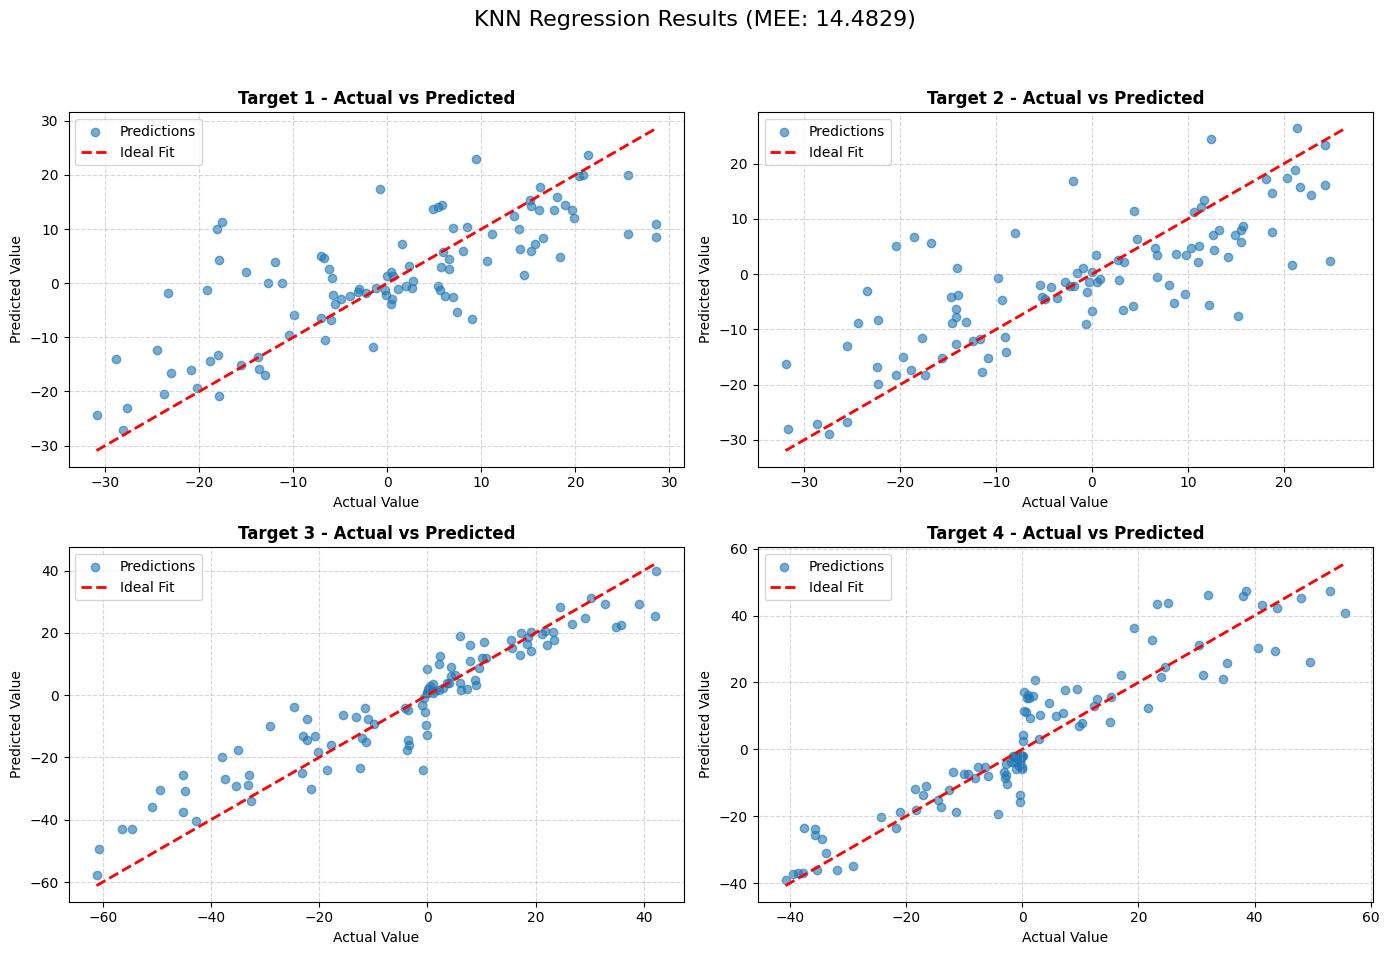


Processing complete.


In [10]:
# ==============================================================================
# 4. VISUALIZATION
# ==============================================================================

# Plot Actual vs. Predicted values for each target
target_labels = ['Target 1', 'Target 2', 'Target 3', 'Target 4']

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.ravel()

for i in range(4):
    # Scatter plot
    axs[i].scatter(y_test[:, i], y_pred[:, i], alpha=0.6, color='#1f77b4', label='Predictions')

    # Perfect prediction line (x = y)
    min_val = min(y_test[:, i].min(), y_pred[:, i].min())
    max_val = max(y_test[:, i].max(), y_pred[:, i].max())
    axs[i].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Ideal Fit')

    # Labels and Title
    axs[i].set_title(f'{target_labels[i]} - Actual vs Predicted', fontsize=12, fontweight='bold')
    axs[i].set_xlabel('Actual Value', fontsize=10)
    axs[i].set_ylabel('Predicted Value', fontsize=10)
    axs[i].legend(loc='upper left')
    axs[i].grid(True, linestyle='--', alpha=0.5)

plt.suptitle(f'KNN Regression Results (MEE: {mee:.4f})', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout for main title
plt.show()

print("\nProcessing complete.")